In [1]:
%load_ext autoreload
%autoreload 2
import os
from pylab import *


import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import xarray as xr
import pathlib
from scipy.signal import convolve2d
from scipy.ndimage import median_filter
import copy
from scipy.io import loadmat

def conv2(x, y, mode='same'):
    return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)

import drama.geo as sargeo
import drama.utils as drtls
from stereoid.oceans import (
    RetrievalModel,
    ObsGeo,
    SceneGenerator,
    RadarModel,
    #read_GoM_scenario,
    FwdModelRIM,
)
from drama.geo.derived_geo import BistaticRadarGeometry
from stereoid.oceans.read_scenario_California import read_scenario_California
import stereoid.sar_performance as strsarperf
import stereoid.utils.config as st_config
import stereoid.oceans.visualization.geo_plot as gplt

# Load results and inputs

In [2]:
paths = st_config.parse(config_file_path=pathlib.Path("/Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg"),section="Paths")
# Unpack the paths read from user.cfg. If user.cfg is not found user_defaults.cfg is used.
main_dir = paths["main"]
datadir = paths["data"]
pardir = paths["par"]
resultsdir = paths["results"]
scn_file = 'California/ocean_lionel.mat'
scn_dir = '/Users/marcelmac/Data/OceanModels/'
swan_file = 'hsCal_T01.mat'
swan_dir = os.path.join(resultsdir,'SWAN/California')
l1_dir = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/LUT')
l1_dir_swan = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/SWAN_noneq')
nrcs_file = 'nrcs_L1_All_obs_California_T01_P10_LUT_002_375_x_150_390_y_150_600_rot_-14_10.nc'
nrcs_file_swan = 'nrcs_L1_All_obs_California_T01_P10_SWAN_noneq_002_375_x_150_390_y_150_600_rot_-14_10.nc'
dop_file = 'dop_L1_All_obs_California_T01_P10_LUT_002_375_x_150_390_y_150_600_rot_-14_10.nc'
dop_file_swan = 'dop_L1_All_obs_California_T01_P10_SWAN_noneq_002_375_x_150_390_y_150_600_rot_-14_10.nc'
imacs_file= 'imacs_L1_All_obs_California_T01_P10_LUT_002_375_x_150_390_y_150_600_rot_-14_10.nc'
imacs_file_swan= 'imacs_L1_All_obs_California_T01_P10_SWAN_noneq_002_375_x_150_390_y_150_600_rot_-14_10.nc'
cutoff_file='cut_off_L1_All_obs_California_T01_P10_LUT_002_375_x_150_390_y_150_600_rot_-14_10.nc'
cutoff_file_swan='cut_off_L1_All_obs_California_T01_P10_SWAN_noneq_002_375_x_150_390_y_150_600_rot_-14_10.nc'
#scndir = os.path.join(datadir, "Ocean/Scenarios")
#plotdir = os.path.join(os.path.join(resultsdir, "SWB_plots"), "California")
plotdir = '/Users/marcelmac/Documents/Papers/ScientificWorkbenchPart1/Figures/'
os.makedirs(plotdir, exist_ok=True)
scnname='California'
print(l1_dir)
#/Users/marcelmac/Data/Harmony/RESULTS/OceanE2E/Scenarios/California/T01/LUT

/Users/marcelmac/PythonProjects/stereoid /Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg
/Users/marcelmac/Data/Harmony/RESULTS/OceanE2E/Scenarios/California/T01/LUT


In [3]:
xrL1nrcs = xr.open_dataset(os.path.join(l1_dir,nrcs_file))
xrL1dop = xr.open_dataset(os.path.join(l1_dir,dop_file))
xrL1imacs = xr.open_dataset(os.path.join(l1_dir,imacs_file))
xrL1cutoff = xr.open_dataset(os.path.join(l1_dir,cutoff_file))
xrL1nrcs_swan = xr.open_dataset(os.path.join(l1_dir_swan,nrcs_file_swan))
xrL1dop_swan = xr.open_dataset(os.path.join(l1_dir_swan,dop_file_swan))
xrL1imacs_swan = xr.open_dataset(os.path.join(l1_dir_swan,imacs_file_swan))
xrL1cutoff_swan = xr.open_dataset(os.path.join(l1_dir_swan,cutoff_file_swan))
cali_data, dx = read_scenario_California(os.path.join(scn_dir, scn_file), smp_out=1e3)
hs_data = loadmat(os.path.join(swan_dir, swan_file))
xrInput = xr.Dataset({"U10s":(("az", "gr"), np.linalg.norm(cali_data["wnd"], axis=-1)),
                      "TSC":(("az", "gr"), np.linalg.norm(cali_data["tsc"], axis=-1)),
                      "SST":(("az","gr"), cali_data["sst"]),
                      "Hs":(("az","gr"), hs_data["Hsig"]),
                      "latitude":(("az","gr"), cali_data["lat"]),
                      "longitude":(("az","gr"), cali_data["lon"])})
xrVecInput = xr.Dataset({"U10s":(("az", "gr","di"), cali_data["wnd"]),
                      "latitude":(("az","gr"), cali_data["lat"]),
                      "longitude":(("az","gr"), cali_data["lon"])})

# Show model inputs

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/2095037373.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('inferno', 14)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/2095037373.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('viridis', 15)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/2095037373.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('Blues', 10)
/

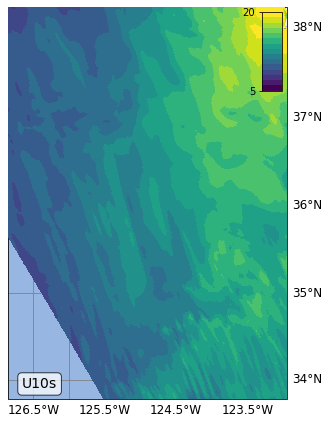

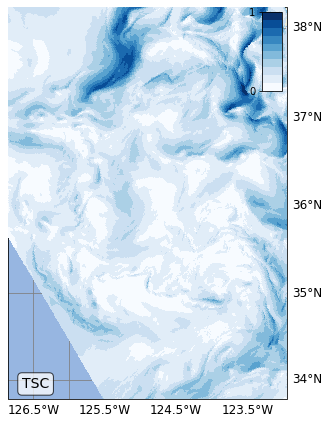

In [4]:
lon_range = [xrL1nrcs.longitude.values[2:-2].min(), xrL1nrcs.longitude.values[2:-2].max()]
lat_range = [xrL1nrcs.latitude.values[2:-2].min(), xrL1nrcs.latitude.values[2:-2].max()]
#gplt.geoplot(xrInput, "SST", sat='HA', cmap='inferno',bvarname="U10s",vmin=8, vmax=15,cblabelcolor='black')
#plt.savefig(os.path.join(plotdir,('%s_inputSST_full.png' % scnname)), dpi=300)
cmap=cm.get_cmap('inferno', 14)
gplt.geoplot(xrInput, "SST", sat='HA', cmap='inferno',bvarname="U10s",vmin=8, vmax=15,cblabelcolor='white',
             lat_range=lat_range, lon_range=lon_range, txt='SST',figsize=(5, 10))
#plt.tight_layout()

cmap=cm.get_cmap('viridis', 15)
plt.savefig(os.path.join(plotdir,('%s_inputSST.png' % scnname)), dpi=300, bbox_inches='tight')
gplt.geoplot(xrInput, "U10s", sat='HA', cmap=cmap,bvarname="U10s",vmin=5, vmax=20,cblabelcolor='black',
             lat_range=lat_range, lon_range=lon_range, txt='U10s',figsize=(5, 10))
#plt.tight_layout()

cmap=cm.get_cmap('Blues', 10)
plt.savefig(os.path.join(plotdir,('%s_inputU10s.png' % scnname)), dpi=300,bbox_inches='tight')
gplt.geoplot(xrInput, "TSC", sat='HA', cmap=cmap,bvarname="TSC",vmin=0, vmax=1,cblabelcolor='black',
             lat_range=lat_range, lon_range=lon_range, txt='TSC',figsize=(5, 10))
#plt.tight_layout()

cmap=cm.get_cmap('cividis', 10)
plt.savefig(os.path.join(plotdir,('%s_inputTSC.png' % scnname)), dpi=300,bbox_inches='tight')
gplt.geoplot(xrInput, "Hs", sat='HA', cmap=cmap,bvarname="Hs",vmin=0, vmax=5,cblabelcolor='black',
             lat_range=lat_range, lon_range=lon_range, txt='Hs',figsize=(5, 10))
#plt.tight_layout()
plt.savefig(os.path.join(plotdir,('%s_inputHs.png' % scnname)), dpi=300,bbox_inches='tight')

In [5]:
#xrVecInput['U10s']=xrVecInput['U10s'].fillna(0)
#gplt.geoquiver(xrVecInput, xrVecInput["U10s"], decim=5, bvarname='U10s', figsize=(10, 20),scale=500,
#               cmap='viridis',lon_range=lon_range, lat_range=lat_range, cblabelcolor='black')
#print(xrVecInput)

# L1 data


/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/136730188.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('gray', 12)


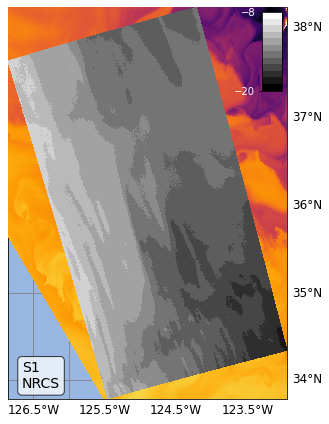

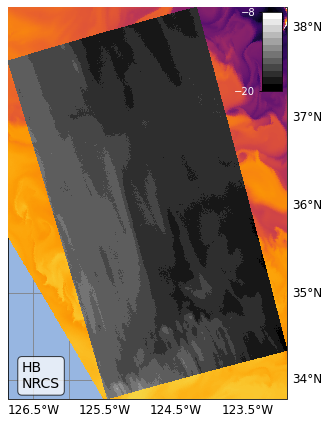

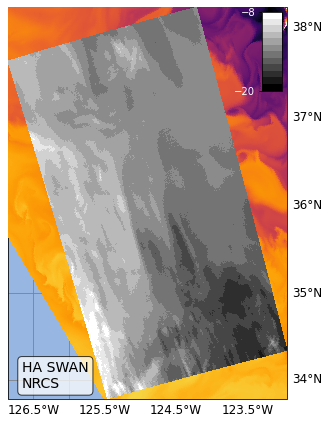

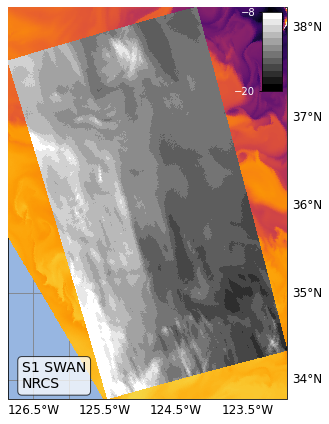

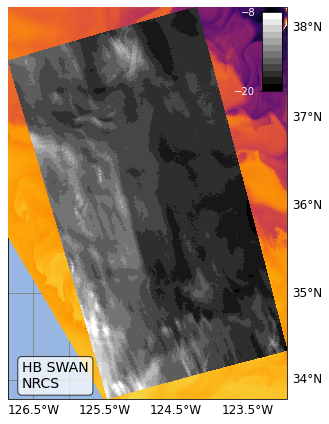

In [6]:
sats = ['HA', 'S1',  'HB']
cmap=cm.get_cmap('gray', 12)
for sat in sats:
    gplt.geoplot(xrL1nrcs, "nrcs", sat=sat, cmap=cmap,vmin=-20, vmax=-8,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat,'NRCS'])
    plt.savefig(os.path.join(plotdir,('%s_NRCS_%s.png' % (scnname, sat))), dpi=300,bbox_inches='tight')
sats = ['HA', 'S1',  'HB']
for sat in sats:
    gplt.geoplot(xrL1nrcs_swan, "nrcs", sat=sat, cmap=cmap,vmin=-20, vmax=-8,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat + ' SWAN','NRCS'])
    plt.savefig(os.path.join(plotdir,('%s_NRCS_%s_swan.png' % (scnname, sat))), dpi=300,bbox_inches='tight')

In [7]:
cmap=cm.get_cmap('RdGy', 11)
xrL1nrcs_dif=copy.deepcopy(xrL1dop) # note it is not dop, but it is to overwrite the dB conversion
xrL1nrcs_dif['dop'][:,:,:,:]=(xrL1nrcs['nrcs'][:,:,:,:]-xrL1nrcs_swan['nrcs'][:,:,:,:])/xrL1nrcs['nrcs'][:,:,:,:]
for sat in sats:
    gplt.geoplot(xrL1nrcs_dif, "dop", sat=sat, cmap=cmap,vmin=-0.5,vmax=0.5,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=[sat + ' diff','nrcs'])
    plt.savefig(os.path.join(plotdir,('%s_NRCS_%s_dif.png' % (scnname, sat))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/454117299.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdGy', 11)


/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/2484997193.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdBu', 17)


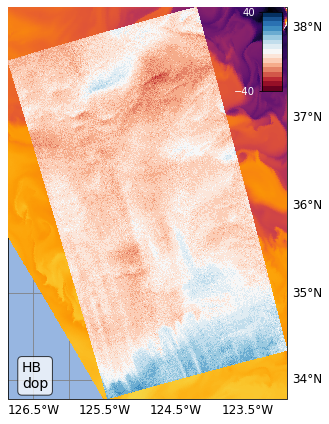

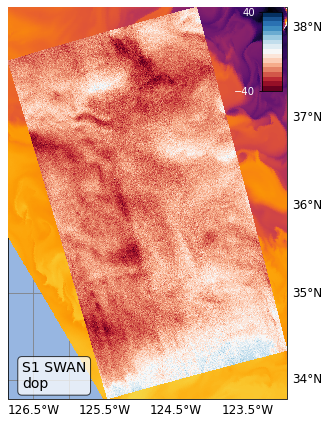

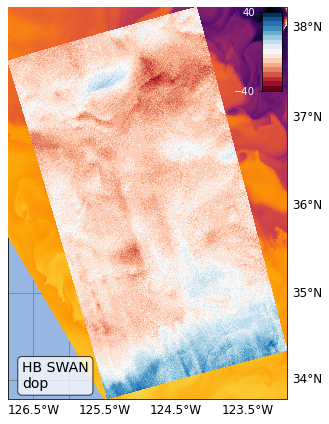

In [8]:
cmap=cm.get_cmap('RdBu', 17)
for sat in sats:
    gplt.geoplot(xrL1dop, "dop", sat=sat, cmap=cmap,vmin=-40, vmax=40,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat,'dop'])
    plt.savefig(os.path.join(plotdir,('%s_GDC_%s.png' % (scnname, sat))), dpi=300,bbox_inches='tight')
for sat in sats:
    gplt.geoplot(xrL1dop_swan, "dop", sat=sat, cmap=cmap,vmin=-40, vmax=40,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat + ' SWAN','dop'])
    plt.savefig(os.path.join(plotdir,('%s_GDC_%s_swan.png' % (scnname, sat))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/807725910.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdGy', 11)


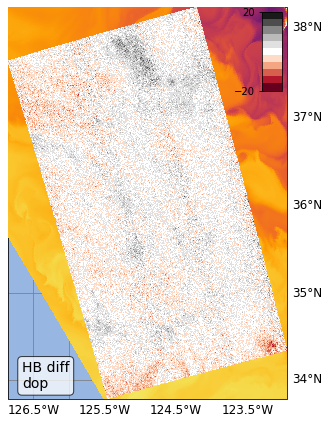

In [9]:
cmap=cm.get_cmap('RdGy', 11)
xrL1dop_dif=copy.deepcopy(xrL1dop)
xrL1dop_dif['dop'][:,:,:,:]=xrL1dop['dop'][:,:,:,:]-xrL1dop_swan['dop'][:,:,:,:]
for sat in sats:
    gplt.geoplot(xrL1dop_dif, "dop", sat=sat, cmap=cmap,vmin=-20, vmax=20,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='inferno', bvarname='SST', alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=[sat + ' diff','dop'])
    plt.savefig(os.path.join(plotdir,('%s_GDC_%s_dif.png' % (scnname, sat))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/2735033887.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdBu', 21)


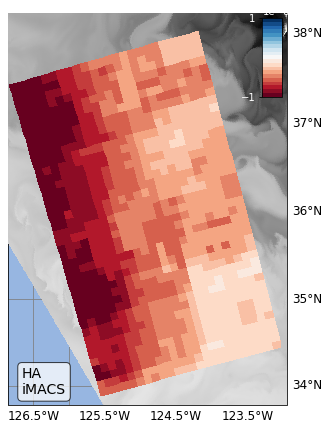

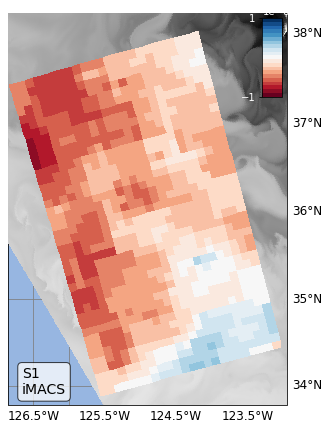

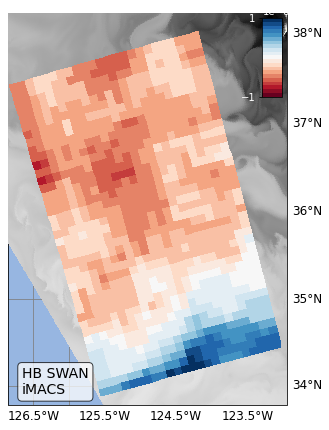

In [10]:
sig=1
n=np.arange(-3*sig,3*sig+1)
f=np.outer(np.exp(-0.5*n**2/sig**2),np.exp(-0.5*n**2/sig**2))
f=f/np.sum(f)

xrL1imacs_filt=copy.deepcopy(xrL1imacs)
xrL1imacs_swan_filt=copy.deepcopy(xrL1imacs_swan)

cmap=cm.get_cmap('RdBu', 21)
for i in range(0,3):
    #xrL1imacs_filt['imacs'][:,:,i,1]=conv2(xrL1imacs['imacs'][:,:,i,1],f,'same')
    #xrL1imacs_swan_filt['imacs'][:,:,i,1]=conv2(xrL1imacs_swan['imacs'][:,:,i,1],f,'same')
    xrL1imacs_filt['imacs'][:,:,i,1]=median_filter(xrL1imacs['imacs'][:,:,i,1],(5,5))
    xrL1imacs_swan_filt['imacs'][:,:,i,1]=median_filter(xrL1imacs_swan['imacs'][:,:,i,1],(5,5))

for sat in sats:
    gplt.geoplot(xrL1imacs_filt, "imacs", sat=sat, cmap=cmap,vmin=-1E-6, vmax=1E-6,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='gray', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat,'iMACS'])
    plt.savefig(os.path.join(plotdir,('%s_iMACS_%s.png' % (scnname, sat))), dpi=300,bbox_inches='tight')
for sat in sats:
    gplt.geoplot(xrL1imacs_swan_filt, "imacs", sat=sat, cmap=cmap,vmin=-1E-6, vmax=1E-6,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='gray', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat + ' SWAN','iMACS'])
    plt.savefig(os.path.join(plotdir,('%s_iMACS_%s_swan.png' % (scnname, sat))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_80588/4060091764.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('plasma', 20)


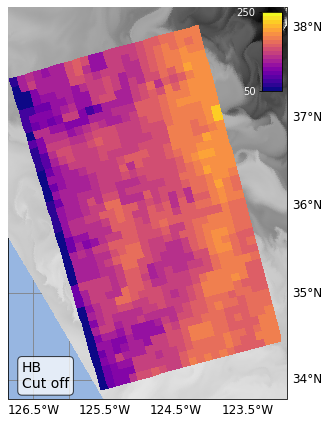

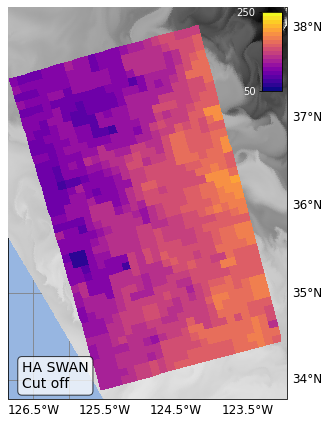

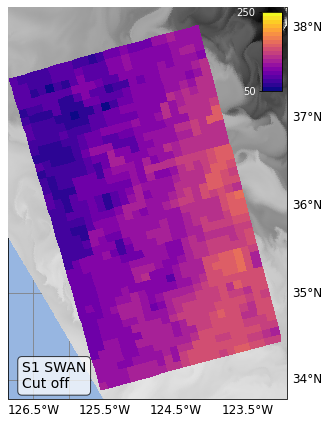

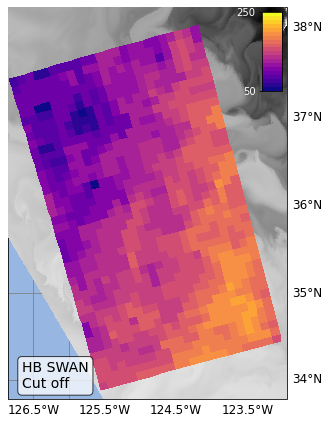

In [11]:
sig=2
n=np.arange(-3*sig,3*sig+1)
f=np.outer(np.exp(-0.5*n**2/sig**2),np.exp(-0.5*n**2/sig**2))
f=f/np.sum(f)

xrL1cutoff_filt=copy.deepcopy(xrL1cutoff)
xrL1cutoff_swan_filt=copy.deepcopy(xrL1cutoff_swan)

cmap=cm.get_cmap('plasma', 20)
for i in range(0,3):
    #xrL1cutoff_filt['cut_off'][:,:,i,1]=conv2(xrL1cutoff['cut_off'][:,:,i,1],f,'same')
    #xrL1cutoff_swan_filt['cut_off'][:,:,i,1]=conv2(xrL1cutoff_swan['cut_off'][:,:,i,1],f,'same')
    xrL1cutoff_filt['cut_off'][:,:,i,1]=median_filter(xrL1cutoff['cut_off'][:,:,i,1],(3,3))
    xrL1cutoff_swan_filt['cut_off'][:,:,i,1]=median_filter(xrL1cutoff_swan['cut_off'][:,:,i,1],(3,3))

for sat in sats:
    gplt.geoplot(xrL1cutoff_filt, "cut_off", sat=sat, cmap=cmap,vmin=50, vmax=250,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='gray', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat,'Cut off'])
    plt.savefig(os.path.join(plotdir,('%s_cutoff_%s.png' % (scnname, sat))), dpi=300,bbox_inches='tight')
for sat in sats:
    gplt.geoplot(xrL1cutoff_swan_filt, "cut_off", sat=sat, cmap=cmap,vmin=50, vmax=250,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range,
                 basedata=xrInput, bcmap='gray', bvarname='SST', alpha=1,bmin=8, bmax=15,cblabelcolor='white',
                 txt=[sat + ' SWAN','Cut off'])
    plt.savefig(os.path.join(plotdir,('%s_cutoff_%s_swan.png' % (scnname, sat))), dpi=300,bbox_inches='tight')